In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import pickle
import os
from os.path import basename, splitext
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from scipy.stats import multivariate_normal, pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
pd.set_option('display.max_columns', 40)
sns.set_theme(context='notebook', style='ticks')
plt.rcParams['axes.facecolor'] = '#fafafa'

from utils.shift import inverse_train_test_procedure
from utils.vis import (plot_performance_scatter, 
                       plot_repr_uncertainty, 
                       METHYLCLOCK_NAMES_MAPPER)

%load_ext autoreload
%autoreload 2

#aux
clocks = pickle.load(open('subdata/clock_coefs.pkl', 'rb'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
#Aging
dfa = pd.read_csv('/home/shappiron/Desktop/Bio/Antiaging/Dynamics of aging/data/GSE87571/data_joined.csv', 
                  index_col=0)
meta = pd.read_csv('/home/shappiron/Desktop/Bio/Antiaging/Dynamics of aging/data/GSE87571/descriptions_samples.csv', 
                   index_col=0)
dfa = dfa[meta.index].T
print('Age, N sites', len(dfa.index))

#Reprogramming
dfr, metr = pd.read_pickle('./datasets/GSE54848.pkl').values()
dfr = dfr.loc[metr.index]

print('Age, N sites', len(dfr.columns))

Age, N sites 729
Age, N sites 485577


# 1D demonstration of epistemic uncertainty estimation with Gaussian Process regressor

Dataset dimensionality: (729, 1)
The CpG site used: cg16867657
R2 train = 0.9111736240005852
R2 test = 0.903859382399119
MAE train = 4.905187379469079
MAE test = 4.910198155051412
------------------------------
Resulting kernel: 53.5**2 * RBF(length_scale=0.311) + WhiteKernel(noise_level=40)


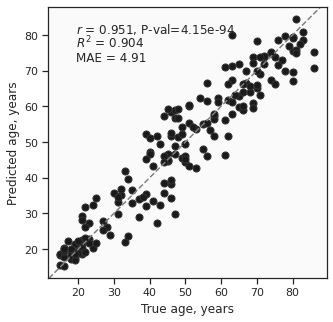

In [16]:
clock = clocks['Skin clock (391 CpGs)']
sites = clock.index.intersection(dfr.columns).intersection(dfa.columns)

sites_ = dfa[sites].corrwith(meta['age']).sort_values(ascending=False).index[[0]]

Xa_clock = dfa[[sites_[0]]]
Xr_clock = dfr[[sites_[0]]]

print("Dataset dimensionality:", Xa_clock.shape)
print("The CpG site used:", sites_[0])

ya = meta['age']
yr = metr['DayReprog'].values

X_train, X_test, y_train, y_test = train_test_split(Xa_clock, ya, test_size=0.25, random_state=10)


### TRAINING ###
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

kernel = (1 * RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + 
          WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
          )
         
model = GaussianProcessRegressor(kernel=kernel, normalize_y=False, n_restarts_optimizer=3)
model.fit(X_train, y_train)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

print(f'R2 train = {r2_score(y_train, y_train_predict)}')
print(f'R2 test = {r2_score(y_test, y_test_predict)}')
print(f'MAE train = {mean_absolute_error(y_train, y_train_predict)}')
print(f'MAE test = {mean_absolute_error(y_test, y_test_predict)}')
print('-'*30)
print("Resulting kernel:", model.kernel_)

plot_performance_scatter(y_test, y_test_predict, eq_bounds=(35, 80), )

We see a good performance of GP model trained with only 1 CpG site.

/home/shappiron/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


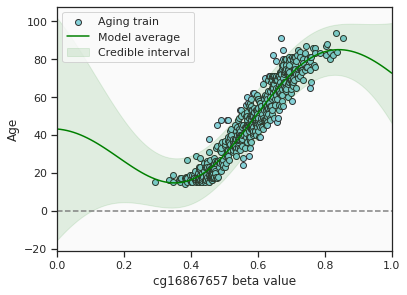

In [17]:
idsort = np.argsort(X_train.iloc[:, 0]).values
x_train = X_train.iloc[idsort, :]
y_train_predict, y_train_std = model.predict(x_train, return_std=True)

x_train2 = np.linspace(0, 1, 100)[:, None]
y_train_predict2, y_train_std2 = model.predict(x_train2, return_std=True)


plt.figure(figsize=(6, 4.5))
plt.scatter(x_train.iloc[:, 0], y_train[idsort], label='Aging train', edgecolors='#333333', color='#86d2da')
plt.plot(x_train2[:, 0], y_train_predict2,color='green', label='Model average')
plt.fill_between(x_train2[:, 0], 
                 y_train_predict2 + 2*y_train_std2, 
                 y_train_predict2 - 2*y_train_std2, 
                 alpha=0.1, color='green', label='Credible interval')

plt.xlim([0, 1.0])
plt.axhline(0, color='grey', ls='--')
plt.ylabel('Age')
plt.xlabel(f'{sites_[0]} beta value')
plt.legend(loc='upper left')
plt.savefig('figs/A4_gp_idea_train.pdf', format='pdf', bbox_inches='tight')
plt.show()

/home/shappiron/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


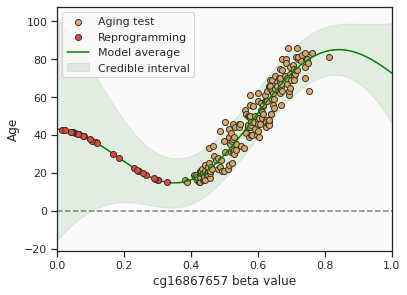

In [18]:
idsort = np.argsort(X_test.iloc[:, 0]).values
x_test = X_test.iloc[idsort, :]
y_test_predict, y_test_std = model.predict(x_test, return_std=True)

x_test2 = np.linspace(0, 1, 100)[:, None]
y_test_predict2, y_test_std2 = model.predict(x_test2, return_std=True)
y_test_predict_r, y_test_std_r = model.predict(Xr_clock, return_std=True)

plt.figure(figsize=(6, 4.5))
plt.scatter(x_test.iloc[:, 0], y_test[idsort], label='Aging test', color='#f9a86f', edgecolors='#333333')

plt.scatter(Xr_clock.iloc[:, 0], y_test_predict_r, color='#f24734', label='Reprogramming', 
            zorder=3, edgecolors='#333333')
plt.plot(x_test2[:, 0], y_test_predict2, color='green', label='Model average')
plt.fill_between(x_test2[:, 0], 
                 y_test_predict2 + 2*y_test_std2, 
                 y_test_predict2 - 2*y_test_std2, 
                 alpha=0.1, color='green', label='Credible interval')


plt.xlim([0, 1.0])
plt.axhline(0, color='grey', ls='--')
plt.ylabel('Age')
plt.xlabel(f'{sites_[0]} beta value')
plt.legend(loc='upper left')
plt.savefig('figs/A4_gp_idea_test.pdf', format='pdf', bbox_inches='tight')
plt.show()